# Load data

In [49]:
import pandas as pd
import numpy as np
import random
import requests
import warnings
from scipy import stats
from datetime import datetime, timedelta
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [4]:
# Read 8-K files into files
record = pd.read_csv('record.csv')

files = []
for index, value in record.iterrows():
    path = '8-K/' + str(value['CIK']) + '-' + value['Date'] + '.txt'
    f = open(path,'r')
    file = f.read()
    files.append(file)

In [302]:
# Read all 8-K items file
items = pd.read_csv('items.csv')['0']

In [60]:
items.head()

0     2. acquisition or disposition of assets.   th...
1     5. other events.   on january 27, 1995, itt f...
2     7. financial statements, pro forma financial ...
3     7(b) has not beenincluded in this filing beca...
4     5.  other events.   on december 9, 1994, meri...
Name: 0, dtype: object

In [456]:
# Read all 8-K items file
items = pd.read_csv('items_cleaned.csv')['0']

In [457]:
items.head()

0    acquisit disposit asset registr announc januar...
1    event januari itt financi corpor wholli own su...
2    financi statement pro forma financi inform exh...
3    b not beeninclud file impractic prepar financi...
4    event decemb meridian bancorp inc meridian and...
Name: 0, dtype: object

In [460]:
test = pd.read_csv('labeled_cleaned.csv')
test.head()

,labels,0
0,1,instanc intern fraud caus larg loss bank bare ...
1,1,we million steal central bank bangladesh crimi...
2,1,four new zealand bank face back tax total bill...
3,1,septemb terrorist attack destroy infrastructur...
4,1,signific delay retail payment new zealand due ...


# Labeling Functions

## Labels

First, let us look at some operational risk events, according to Basel II operational risk event type classification. We only use the level 1 events here. Each events have a defination.

https://www.cia-ica.ca/docs/default-source/2014/214118e.pdf    

In [69]:
labels = ['Internal Fraud','External Fraud', 'Employment Practices and Workplace Safety', 'Clients, Products and Business Practices', 'Damage to Physical Assets', 'Business disruption and system failures', 'Execution, Delivery and Process Management']
levels = ['high', 'medium', 'low']

In [68]:
labels

['Internal Fraud',
 'External Fraud',
 'Employment Practices and Workplace Safety',
 'Clients, Products and Business Practices',
 'Damage to Physical Assets',
 'Business disruption and system failures',
 'Execution, Delivery and Process Management']

## Keyword Extraction

In [76]:
# https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c
# spaCy

import spacy
nlp = spacy.load("en_core_web_sm")
text = """spaCy is an open-source software library for advanced natural language processing, 
written in the programming languages Python and Cython. The library is published under the MIT license
and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion."""
doc = nlp(text)
print(doc.ents)


(Python and Cython, MIT, Matthew Honnibal, Ines Montani, Explosion)


In [85]:
# TF – IDF 
from nltk import tokenize
from operator import itemgetter
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinyue/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [877]:
# https://www.analyticsvidhya.com/blog/2020/11/words-that-matter-a-simple-guide-to-keyword-extraction-in-python/

# Remove stopwords
stop_words = set(stopwords.words('english'))

def TFIDF(doc, n):
    # Find total words in the document 
    total_words = doc.split()
    total_word_length = len(total_words)
    # print(total_word_length)

    # Find the total number of sentences
    total_sentences = tokenize.sent_tokenize(doc)
    total_sent_len = len(total_sentences)
#     print(total_sent_len)

    # Calculate TF for each word
    tf_score = {}
    for each_word in total_words:
        each_word = each_word.replace('.','')
        if each_word not in stop_words:
            if each_word in tf_score:
                tf_score[each_word] += 1
            else:
                tf_score[each_word] = 1

    # Dividing by total_word_length for each dictionary element
    tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())
    # print(tf_score)

    # Function to check if the word is present in a sentence list
    def check_sent(word, sentences): 
        final = [all([w in x for w in word]) for x in sentences] 
        sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
        return int(len(sent_len))

    # Calculate IDF for each word
    idf_score = {}
    for each_word in total_words:
        each_word = each_word.replace('.','')
        if each_word not in stop_words:
            if each_word in idf_score:
                idf_score[each_word] = check_sent(each_word, total_sentences)
            else:
                idf_score[each_word] = 1

    # Performing a log and divide
    idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())
    # print(idf_score)

    # Calculate TF * IDF
    tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}
    # print(tf_idf_score)

    # Create a function to get N important words in the document
    def get_top_n(dict_elem, n):
        result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]).keys()
        return result

    # Get the top 5 words of significance
    return list(get_top_n(tf_idf_score, n))

In [124]:
len(items)

2584

In [881]:
import re
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import xlrd
import numpy as np
import lda
import pandas as pd

# Return the stem of words
def stem(word):
    return PorterStemmer().stem(word)

# Remove common words for a text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    # filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = ''
    for w in word_tokens:
        if w not in stop_words and len(w) > 2 and len(w)<15:
            filtered_sentence = filtered_sentence + w + ' '
    return filtered_sentence

def parse_text(text):
    s = re.sub(r'\.[^.]+$', '.', text)
    if '-' in s:
        s = s[s.index('-') + 1:]

    s = s.lower()
    words = re.findall(r'[a-z]+', s)
    return words

def find_keywords(documents): 
    
    # Remove common words for a document
    for i in range(0, len(documents)):
        documents[i] = remove_stopwords(str(documents[i]))
    
    unique_words = set()
    print("Reading and parsing the documents...")
    for document in documents:
        for word in document.split():
            unique_words.add(stem(word))
            #unique_words.add(word)
    vocab = tuple(unique_words)
    
    print("Creating the LDA matrix...")
    X = np.zeros((len(documents), len(vocab)), "int32")
    for i in range(0, len(documents)):
        for word in documents[i].split():
            X[i, vocab.index(stem(word))] += 1
            #X[i, vocab.index(word)] += 1
    
    print("Performing LDA...")
    model = lda.LDA(n_topics=7, n_iter=100, random_state=1) # number of topics
    model.fit(X)
    topic_word = model.topic_word_ # number of unique words
    n_top_words = 20 # max number of words per topic
    
    ans = []
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        #print('Topic {}: {}'.format(i, ' '.join(topic_words)))
        ans.append(' '.join(topic_words))
    return ans
print(find_keywords(items))

Reading and parsing the documents...
Creating the LDA matrix...


INFO:lda:n_documents: 2575
INFO:lda:vocab_size: 14522
INFO:lda:n_words: 245049
INFO:lda:n_topics: 7
INFO:lda:n_iter: 100


Performing LDA...


INFO:lda:<0> log likelihood: -2379560
INFO:lda:<10> log likelihood: -1932687
INFO:lda:<20> log likelihood: -1850920
INFO:lda:<30> log likelihood: -1827776
INFO:lda:<40> log likelihood: -1816279
INFO:lda:<50> log likelihood: -1809843
INFO:lda:<60> log likelihood: -1803736
INFO:lda:<70> log likelihood: -1799494
INFO:lda:<80> log likelihood: -1795834
INFO:lda:<90> log likelihood: -1793243
INFO:lda:<99> log likelihood: -1791577


['compani offic director execut board plan employ agreement certain stock chief presid perform year compen annual appoint base award bonu', 'compani registr account vote director propo meet statement year approv board financ report stockhold decemb audit proxi matter sharehold chang', 'exhibit financ file relea statement press inform report refer incorpor act form secur exchang amend date result compani section attach', 'note agreement date trust secur certif class registr offer bank seri credit may inc servic amount exhibit compani pursuant term', 'oper may busi result includ statement manag forwardlook school compani financ market expect risk futur high materi could tax develop', 'loan balanc interest total princip distribut financ end day oblig amount net rate consolid loss year statement group account incom', 'agreement share stock compani common purcha merger right price close date acquisit subsidiari parti transact per inc million amend outstand']


In [466]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [565]:
import string

def re_text(text, num = 30):
    punctuation_string = string.punctuation
    for i in punctuation_string:
        text = text.replace(i, '')
    text = remove_stopwords(text)
    text = simple_stemmer(text)
    temp = TFIDF(text.lower(), num)
    result = ''
    for word in temp[:len(temp)-1]:
        result = result + word + '|'
    result = result + temp[len(temp)-1]
    return result

In [479]:
text1 = 'circumvent regulation Unauthorised Transactions intentional Transaction unauthorised monetary Mismarking of intention Theft and worthless deposits Theft / extortion / embezzlement / robbery Misappropriation of Malicious destruction of  Forgery Check kiting Smuggling Account take-over / impersonation / Tax non-compliance / evasion (wilful) Bribes / kickbacks Insider trading'
text2 = 'circumvent Theft Fraud Robbery Forgery Check kiting Systems Security Hacking damage of information monetary'
text3 = 'employment, health or safety agreements, from payment of personal injury claims, or from diversity discrimination events. Employee Relations Compensation, benefit, termination Organised labour Safe Environment Employee health & safety rules events Workers compensation Diversity & Discrimination discrimination'
text4 = 'unintentional or negligent to obligation to specific clients fiduciary and suitability product. Suitability, Disclosure & Fiduciary Fiduciary breaches  violations Suitability / disclosure Retail disclosure violations Breach of privacy Aggressive churning Misuse of confidential Lender Improper or Practices Antitrust Improper trade / market Market manipulation Insider trading Unlicensed laundering Product Flaws Product defects (unauthorised, etc.) Model errors Selection, Sponsorship & Exposure Failure to investigate per guidelines Exceeding client exposure limits Advisory Activities Disputes over performance of advisory activities'
text5 = 'damage to physical from natural disaster. Disasters and other events Natural disaster from external sources terrorism, vandalism'
text6 = 'disruption of business or system failures Hardware Software Telecommunications Utility outage / disruptions'
text7 = 'failed transaction processing or process management, from relations with trade counterparties and vendors Transaction Capture, Execution & Maintenance Miscommunication entry, maintenance or loading error Missed deadline or responsibility Model / system misoperatio error / attribution error misperformance Delivery failure Collateral Reference Maintenance Monitoring and mandatory obligation Inaccurate external Customer Intake and Documentation Client permissions / disclaimers Legal documents / incomplete Customer / Client Account Management Unapproved access given to Incorrect client Negligent Trade Counterparties Non-client counterparty misperformance Misc. non-client counterparty disputes Vendors & Suppliers Outsourcing Vendor disputes'


In [480]:
# For clarity, we define constants to represent the class labels for YES, NO, ABSTAIN.
ABSTAIN = -1
NO = 0
YES = 1

In [655]:
from snorkel.labeling import labeling_function

# Hand-Defined Labeling Functions
InternalFraud = re_text(text1)
@labeling_function()
def internalfraud(document):
    return YES if re.search(InternalFraud, str(document)) else ABSTAIN

# InternalFraud2 = 'diversity|discrimination'
# @labeling_function()
# def internalfraud2(document):
#     return No if re.search(InternalFraud2, str(document)) else ABSTAIN

ExternalFraud = re_text(text2)
@labeling_function()
def externalfraud(document):
    return YES if re.search(ExternalFraud, str(document)) else ABSTAIN

EmploymentWorkplace = re_text(text3)
@labeling_function()
def employmentworkplace(document):
    return YES if re.search(EmploymentWorkplace, str(document)) else ABSTAIN

ClientsProducts = re_text(text4)
@labeling_function()
def clientsproducts(document):
    return YES if re.search(ClientsProducts, str(document)) else ABSTAIN

PhysicalAssets = re_text(text5)
@labeling_function()
def physicalassets(document):
    return YES if re.search(PhysicalAssets, str(document)) else ABSTAIN

DisruptionSystem = re_text(text6)
@labeling_function()
def disruptionsystem(document):
    return YES if re.search(DisruptionSystem, str(document)) else ABSTAIN

ExecutionDelivery = re_text(text7)
@labeling_function()
def executiondelivery(document):
    return YES if re.search(ExecutionDelivery, str(document)) else ABSTAIN

In [656]:
df_train = pd.DataFrame(items)
df_train

,0
0,acquisit disposit asset registr announc januar...
1,event januari itt financi corpor wholli own su...
2,financi statement pro forma financi inform exh...
3,b not beeninclud file impractic prepar financi...
4,event decemb meridian bancorp inc meridian and...
...,...
2570,amend articl incorpor bylaw chang fiscal year ...
2571,event novemb board director declar initi quart...
2572,result oper financi condit octob nuvas inc com...
2573,regul fd disclosur confer call schedul hold p ...


In [657]:
from snorkel.labeling import PandasLFApplier

lfs = [
    internalfraud, 
#     internalfraud2, 
    externalfraud, 
    employmentworkplace, 
    clientsproducts, 
    physicalassets, 
    disruptionsystem, 
    executiondelivery]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 2575/2575 [00:04<00:00, 535.50it/s]


In [341]:
# L_train

# c) Evaluate performance on training set¶

In [658]:
coverage = (L_train != ABSTAIN).mean(axis=0)
print(f"coverage:", coverage)

coverage: [0.13553398 0.14291262 0.24932039 0.09398058 0.16854369 0.00970874
 0.16      ]


In [659]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
internalfraud,0,[1],0.135534,0.081553,0.0
externalfraud,1,[1],0.142913,0.048544,0.0
employmentworkplace,2,[1],0.249320,0.235728,0.0
clientsproducts,3,[1],0.093981,0.088544,0.0
physicalassets,4,[1],0.168544,0.166990,0.0
disruptionsystem,5,[1],0.009709,0.007379,0.0
executiondelivery,6,[1],0.160000,0.121165,0.0


In [660]:
# Use a third-party model
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(str(x['0']))
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [661]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return YES if x.polarity < -0.05 else ABSTAIN

In [662]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return NO if x.subjectivity >= 0.4 else ABSTAIN

In [663]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

100%|██████████| 2575/2575 [00:02<00:00, 1013.14it/s]


In [664]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[1],0.149903,0.062136,0.062136
textblob_subjectivity,1,[0],0.299806,0.062136,0.062136


In [665]:
# Heuristic
text = text1 + text2 + text3 + text4 + text5 + text6 + text7
temp = re_text(text, len(text))
tokens_1 = temp.split('|')

import textdistance
@labeling_function()
def similarity(x):
    tokens_2 = str(x['0']).split()
    temp = textdistance.sorensen(tokens_1 , tokens_2)
#     temp = textdistance.jaccard(tokens_1 , tokens_2)
    return YES if temp>0.05 else ABSTAIN

In [666]:
lfs = [similarity]
applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

100%|██████████| 2575/2575 [00:00<00:00, 6027.38it/s]


In [667]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
similarity,0,[1],0.092039,0.0,0.0


In [668]:
# SpaCy English model
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="0", doc_field="doc", memoize=True)

In [669]:
# People, Systems and Processes
@labeling_function(pre=[spacy])
def has_people(x):
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return YES
    else:
        return ABSTAIN

@labeling_function(pre=[spacy])
def has_product(x):
    if len(x.doc) < 20 and any([ent.label_ == "PRODUCT" for ent in x.doc.ents]):
        return YES
    else:
        return ABSTAIN

@labeling_function(pre=[spacy])
def has_event(x):
    if len(x.doc) < 20 and any([ent.label_ == "EVENT" for ent in x.doc.ents]):
        return YES
    else:
        return ABSTAIN

In [670]:
lfs = [
    has_people,
    has_product,
    has_event]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train.dropna())

100%|██████████| 2531/2531 [00:42<00:00, 59.70it/s] 


In [671]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
has_people,0,[1],0.063216,0.0,0.0
has_product,1,[1],0.000395,0.0,0.0
has_event,2,[],0.000000,0.0,0.0


In [446]:
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy import displacy
doc = nlp(items[3])
a = []
for ent in doc.ents:
    a.append(ent.label_)
print(set(a))
displacy.serve(doc, style="ent")

{'DATE', 'CARDINAL'}



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [686]:
df_test = pd.DataFrame(test['0'])

In [691]:
lfs = [
    internalfraud, 
#     internalfraud2, 
    externalfraud, 
    employmentworkplace, 
    clientsproducts, 
    physicalassets, 
    disruptionsystem, 
    executiondelivery,
    similarity,
    textblob_polarity,
    textblob_subjectivity,
    has_people,
    has_product,
    has_event]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train.dropna())
L_test = applier.apply(df=df_test.dropna())

100%|██████████| 10/10 [00:00<00:00, 375.07it/s]


In [674]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
internalfraud,0,[1],0.137890,0.112604,0.026867
externalfraud,1,[1],0.145397,0.088898,0.037535
employmentworkplace,2,[1],0.253655,0.246938,0.101936
clientsproducts,3,[1],0.095614,0.093244,0.022126
physicalassets,4,[1],0.171474,0.170684,0.067562
disruptionsystem,5,[1],0.009878,0.009087,0.003556
executiondelivery,6,[1],0.162782,0.137495,0.062426
similarity,7,[1],0.093639,0.086922,0.045832
textblob_polarity,8,[1],0.152509,0.118530,0.063216
textblob_subjectivity,9,[0],0.305018,0.208613,0.208613


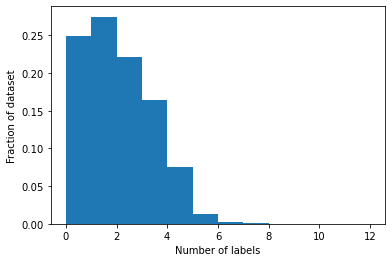

In [675]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [676]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [677]:
preds_train

array([0, 1, 1, ..., 0, 1, 1])

In [678]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
INFO:root:[0 epochs]: TRAIN:[loss=0.202]
INFO:root:[100 epochs]: TRAIN:[loss=0.020]
INFO:root:[200 epochs]: TRAIN:[loss=0.011]
INFO:root:[300 epochs]: TRAIN:[loss=0.010]
INFO:root:[400 epochs]: TRAIN:[loss=0.010]
INFO:root:Finished Training


In [725]:
Y_test = np.array(test['labels'])

In [706]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   40.0%
Label Model Accuracy:     50.0%


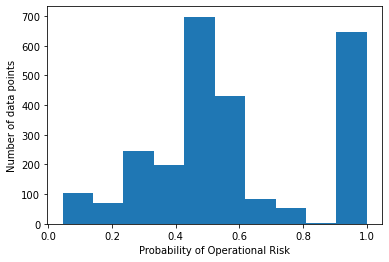

In [707]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of Operational Risk")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, YES])

In [709]:
# Filtering out unlabeled data points
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train.dropna(), y=probs_train, L=L_train
)

# Training a Classifier

In [874]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered['0'].tolist())
X_test = vectorizer.transform(df_test['0'].tolist())

In [787]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)
Y_train = probs_to_preds(probs=probs_train)

In [714]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [715]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 60.0%


In [797]:
train = pd.DataFrame(Y_train, df_train.dropna())
train.head()

,0
"(acquisit disposit asset registr announc januari cash tender offer byan itt subsidiari outstand share common stock caesarsworld inc per share expir share validli tenderedpursu offer accept payment share commonstock caesar world inc repre approxim percent theoutstand share fulli dilut basi final tender theregistr expect consumm merger itt subsidiari caesarsworld inc march caesar world inc oper three hotelcasinosin la vega atlant citi lake taho number non game resort inth pocono mountain pennsylvania conjunct two partner alsomanag casino own ontario govern windsor canada total salesand net incom caesar world inc fiscal year end juli billion million respect,)",1
"(event januari itt financi corpor wholli own subsidiaryof registr announc requisit consent seri beenreceiv consent solicit amend certain coven billionprincip amount public debt secur amend conform thecoven contain recent issu public debt secur theregistr previous announc expect itt financi sellal substanti busi asset variou purchasersdur connect sale plan itt financi willmerg registr thereaft registr becom obligor onth secur,)",1
"(financi statement pro forma financi inform exhibit pro forma financi inform pursuant,)",0
"(b not beeninclud file impractic prepar financialinform file date registr file pro formafinanci inform april see exhibit index exhibit file herewith,)",0
"(event decemb meridian bancorp inc meridian andunit counti bancorpor ucb jointli termin thelett intent date august meridian ucba amend letter agreement date novemb meridian ucb provid merger ucb withand meridian decemb meridian issu press releasereport termin letter intent forego inform qualifi entireti byrefer press relea set forth exhibit hereto incorpor herein refer,)",1


In [798]:
# Store data into excel
train_df = pd.DataFrame(train)
train_df.to_csv('train.csv',encoding='utf-8')

# Neural network

In [801]:
X_train = df_train.dropna()['0']
# Y_train
X_test = test['0']
Y_test = test['labels']

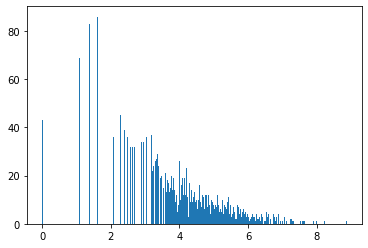

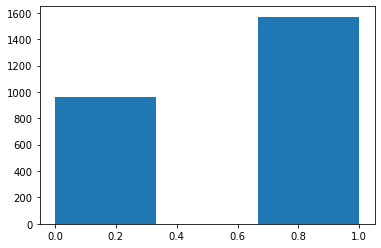

In [814]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') # oov_token is not frequently used words.
tokenizer.fit_on_texts(X_train) # Map texts to numbers

lengths = [len(t.split(' ')) for t in X_train]
plt.hist(np.log(lengths), bins = len(set(lengths))) # take the log transformation
plt.show()

maxlen = 200 #truncate them
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, X_train):
    sequences = tokenizer.texts_to_sequences(X_train)
    padded = pad_sequences(sequences, truncating='post',padding='post', maxlen=maxlen)
    return padded

padded_train_seq = get_sequences(tokenizer, X_train)

padded_train_seq[0]

plt.hist(Y_train, bins = 3)
plt.show()

In [812]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),    
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=2)),  
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)), 
        tf.keras.layers.Dense(6, activation='softmax')                     
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [813]:
tf.keras.layers.Embedding(10000, 16, input_length=maxlen)

In [ ]:
val_X, val_Y = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [815]:
h = model.fit(
    padded_train_seq, Y_train, 
#     validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
80/80 [==============================] - 13s 102ms/step - loss: 0.9763 - accuracy: 0.6006


Epoch 2/20
80/80 [==============================] - 8s 100ms/step - loss: 0.6223 - accuracy: 0.6638


Epoch 3/20
80/80 [==============================] - 8s 95ms/step - loss: 0.4561 - accuracy: 0.8092


Epoch 4/20
80/80 [==============================] - 8s 94ms/step - loss: 0.3538 - accuracy: 0.8503


Epoch 5/20
80/80 [==============================] - 8s 96ms/step - loss: 0.3075 - accuracy: 0.8724


Epoch 6/20
80/80 [==============================] - 8s 96ms/step - loss: 0.2557 - accuracy: 0.8973


Epoch 7/20
80/80 [==============================] - 8s 99ms/step - loss: 0.2265 - accuracy: 0.9072


Epoch 8/20
80/80 [==============================] - 8s 99ms/step - loss: 0.1966 - accuracy: 0.9206


Epoch 9/20
80/80 [==============================] - 8s 103ms/step - loss: 0.1816 - accuracy: 0.9253


Epoch 10/20
80/80 [==============================] - 8s 94ms/step - loss: 0.1778 - accuracy: 0.9313


Epoch 11/20
80/80 [==============================] - 8s 94ms/step - loss: 0.1910 - accuracy: 0.9154


Epoch 12/20
80/80 [==============================] - 8s 97ms/step - loss: 0.1806 - accuracy: 0.9372


Epoch 13/20
80/80 [==============================] - 7s 90ms/step - loss: 0.2044 - accuracy: 0.9198


Epoch 14/20
80/80 [==============================] - 7s 90ms/step - loss: 0.1485 - accuracy: 0.9407


Epoch 15/20
80/80 [==============================] - 7s 92ms/step - loss: 0.1389 - accuracy: 0.9451


Epoch 16/20
80/80 [==============================] - 8s 97ms/step - loss: 0.1536 - accuracy: 0.9522


Epoch 17/20
80/80 [==============================] - 8s 95ms/step - loss: 0.1366 - accuracy: 0.9490


Epoch 18/20
80/80 [==============================] - 8s 95ms/step - loss: 0.1294 - accuracy: 0.9463


Epoch 19/20
80/80 [==============================] - 7s 93ms/step - loss: 0.1152 - accuracy: 0.9490


Epoch 20/20
80/80 [==============================] - 7s 90ms/step - loss: 0.1181 - accuracy: 0.9471


In [834]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
%matplotlib inline

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
#     plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
#     plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

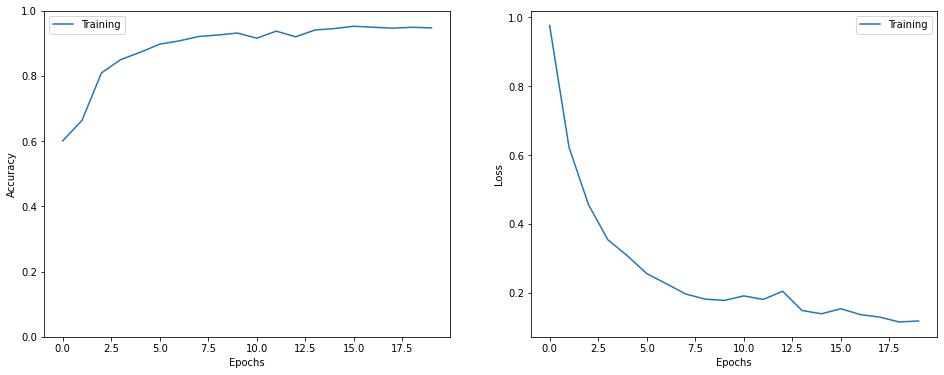

In [820]:
show_history(h)

In [821]:
test_seq = get_sequences(tokenizer, X_test)

In [822]:
model.evaluate(test_seq, Y_test)

1/1 [==============================] - 1s 1s/step - loss: 1.6622 - accuracy: 0.6000


[1.6622047424316406, 0.6000000238418579]

In [823]:
preds = model.predict_classes(test_seq)

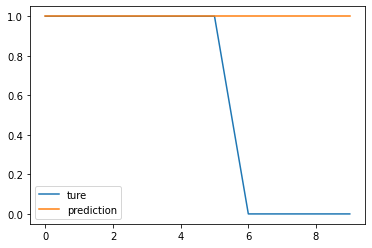

In [846]:
plt.plot(range(0, 10), np.array(Y_test), label='ture')
plt.plot(range(0, 10), preds, label = 'prediction')
plt.legend()

In [873]:
def accur():
    correct = 0
    for i in range(len(preds)):
        if np.array(Y_test)[i] == preds[i]:
            correct = correct + 1
    return correct/len(preds)
print(f"Test Accuracy: {100 * accur():.1f}%")

Test Accuracy: 60.0%


In [888]:
pd.DataFrame([Y_test,preds], index=['test','predict'])

,0,1,2,3,4,5,6,7,8,9
test,1,1,1,1,1,1,0,0,0,0
predict,1,1,1,1,1,1,1,1,1,1


# LSTM (Long Short Term Memory) model,

In [848]:
import tensorflow as tf

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

tf.compat.v1.set_random_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [860]:
# from utils import featurize_df_tokens, get_keras_lstm

def train_and_test(X_train=padded_train_seq, Y_train=Y_train, X_test=test_seq, Y_test=np.array(Y_test), num_buckets=30000):
    # Define a vanilla LSTM model with Keras
    lstm_model = get_keras_lstm(num_buckets)
    lstm_model.fit(X_train, Y_train, epochs=5, verbose=0)
    preds_test = lstm_model.predict(X_test)[:, 0] > 0.5
    return (preds_test == Y_test).mean()

acc_original = train_and_test()

In [861]:
print(f"Test Accuracy: {100 * acc_original:.1f}%")

Test Accuracy: 60.0%
